# Booster vs SHAP Feature Importance

During feature selection, we need to determin the importance of features so we can rank and select accordingly. In this note, I conducted two experiments to compare the performance of two popular feature importance measures: The XGBoost's built-in feature importance and shap importance. 

* **Experiment 1: Main Effects Only**
    * The relationship between the features and the target is relatively simple. We will have 10 features in the dataset, among which only 5 are predictive of the target, and the rest are random features for noise. 
    * We will train two Boruta feature selection models with the exact same configuration, except for the type of feature importance used.
    * We then compare the feature ranking/selection. 

.
* **Experiment 2: Main + Interaction Effects**
    * A moderator is added to the data and two of the predictive feature will have differential impact on the target depending on the value of the moderator. 
    * Again, like experiment 1, we conduct two Boruta feature selection runs, one using booster feature importance, the other using shapp feature importance.  

*TODO:
* A mega-run of experiment 2 using different random numbers for df generating, record
    * times moderator is correctly selected (shap tends to drop the moderator)
    * times random feature is selected (both algorithm tends to confuse on this)
    * times any predictive (informative + main) feature missed (both algorithm tend to perform well)


Before the experiment begin, for background, here is some discussion about how the two measures differ in theory:

* **Methodology**: XGBoost's built-in feature importance is typically calculated based on the number of times a feature is used to split the data in the trees of the ensemble. This approach doesn't consider the interactions between features. On the other hand, SHAP feature importance values take into account the interactions and dependencies between features, providing a more comprehensive view of their influence, which can lead to important differences when features interact with each other in complex ways.

* **Tree Structure**: XGBoost's feature importance is directly related to the structure of the trees in the ensemble. Features that appear early in trees and are used to make important splits will have higher importance scores. SHAP values, on the other hand, consider the contributions of each feature for each individual prediction, allowing for a more nuanced understanding of feature importance.

* **Bias and Noise Handling**: SHAP values aim to provide fair attribution of credit to each feature for each prediction. This includes handling potential bias and noise in the data. XGBoost's feature importance may not be as robust in handling such issues.

* **Regularization**: XGBoost's feature importance can be influenced by regularization parameters, affecting the number of times a feature is used for splits. In contrast, SHAP values consider the contribution of each feature to the prediction directly.


In [123]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from hyperopt import hp, Trials
from shaphypetune import BoostBoruta
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')


# The Experiment

Now let's create two models using the shap-hypetune package. The two models have the same configuration except for one difference: The `importance_type` used in feature selection. 

In [124]:
param_dist_hyperopt = {
    'max_depth': 15 + hp.randint('num_leaves', 5), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

def AUC(y_hat, dtrain):
    y_true = dtrain.get_label()
    return 'auc', roc_auc_score(y_true, y_hat)

clf = xgb.XGBClassifier(n_estimators=150, random_state=123)

In [125]:
model_default = BoostBoruta(clf, 
                        param_grid = param_dist_hyperopt,
                        greater_is_better = True,
                        n_iter = 10, 
                        sampling_seed=123,
                        max_iter=200,
                        perc=100,
                        early_stopping_boruta_rounds = 30,
                        train_importance=True,
                        # the default feature importance of the gradient boosting estimator
                        importance_type = "feature_importances", 
                        )

model_shap = BoostBoruta(clf, 
                        param_grid = param_dist_hyperopt,
                        greater_is_better = True,
                        n_iter = 10, 
                        sampling_seed=123,
                        max_iter=200,
                        perc=100,
                        early_stopping_boruta_rounds = 30,
                        train_importance=True,
                        # the only different configuration between models:
                        importance_type = "shap_importances",
                        )

## Experiment 1: Basic Data

The test data have three types of features. A good feature importance ranking should be able to rank these features accordingly. 

* 5 x informative features
* 5 x random features (i.e., filled with random noise)

In [126]:
n_samples = 2000
n_features = 10
n_informative = 5
n_redundant = 0 
n_classes = 2

X, y = make_classification(n_samples=n_samples, n_features=n_features,
                           n_informative=n_informative, n_redundant=n_redundant,
                           n_classes=n_classes, random_state=12, shuffle=False)

# Create a DataFrame with custom feature names for better visualization
informative_names = [f'informative_{i+1}' for i in range(n_informative)]
redundant_names = [f'redundant_{i+1}' for i in range(n_redundant)]
random_names = [f'random_{i+1}' for i in range(n_features - n_informative - n_redundant)]
feature_names = informative_names + redundant_names + random_names

df = pd.DataFrame(X, columns = feature_names)

In [127]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size = 0.2, stratify=y)

In [107]:
%%time

model_default.fit(
    X_train, y_train,
    trials = Trials(),
    eval_set = [(X_valid, y_valid)],
    early_stopping_rounds=6,
    verbose=6,
    eval_metric=AUC)


10 trials detected for ('max_depth', 'learning_rate', 'colsample_bytree')



Boruta early stopping at iteration 51
trial: 0001 ### iterations: 00009 ### eval_score: 0.96885
trial: 0002 ### iterations: 00025 ### eval_score: 0.97505
trial: 0003 ### iterations: 00023 ### eval_score: 0.97277
trial: 0004 ### iterations: 00009 ### eval_score: 0.96515
Boruta early stopping at iteration 72
trial: 0005 ### iterations: 00022 ### eval_score: 0.9681
trial: 0006 ### iterations: 00008 ### eval_score: 0.96346
Boruta early stopping at iteration 48
trial: 0007 ### iterations: 00009 ### eval_score: 0.96693
trial: 0008 ### iterations: 00025 ### eval_score: 0.97125
trial: 0009 ### iterations: 00047 ### eval_score: 0.97752
trial: 0010 ### iterations: 00030 ### eval_score: 0.97147
CPU times: total: 10min 2s
Wall time: 1min 27s


BoostBoruta(early_stopping_boruta_rounds=30,
            estimator=XGBClassifier(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraint...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
            greater_is_better=True, max_iter=200, n_iter=10,
            param_grid={'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x0000025FA95A63D0>,
                        'learning_rate': <hyperopt.pyll.base.Apply object at 0x0000025FA8B3C220>,
                        'max_depth': <hyperopt.pyll.base.Apply object at 0x0000025FA8B3C8B0>},
            sampling_seed=123)

In [108]:
%%time

model_shap.fit(
    X_train, y_train,
    trials = Trials(),
    eval_set = [(X_valid, y_valid)],
    early_stopping_rounds=6,
    verbose=6,
    eval_metric=AUC)


10 trials detected for ('max_depth', 'learning_rate', 'colsample_bytree')

trial: 0001 ### iterations: 00009 ### eval_score: 0.96885
trial: 0002 ### iterations: 00025 ### eval_score: 0.97505
trial: 0003 ### iterations: 00023 ### eval_score: 0.97277
trial: 0004 ### iterations: 00009 ### eval_score: 0.96515
trial: 0005 ### iterations: 00008 ### eval_score: 0.96351
trial: 0006 ### iterations: 00008 ### eval_score: 0.96346
trial: 0007 ### iterations: 00009 ### eval_score: 0.96693
trial: 0008 ### iterations: 00025 ### eval_score: 0.97125
trial: 0009 ### iterations: 00047 ### eval_score: 0.97752
trial: 0010 ### iterations: 00030 ### eval_score: 0.97147
CPU times: total: 10min 48s
Wall time: 1min 33s


BoostBoruta(early_stopping_boruta_rounds=30,
            estimator=XGBClassifier(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraint...
                                    predictor=None, random_state=123, ...),
            greater_is_better=True, importance_type='shap_importances',
            max_iter=200, n_iter=10,
            param_grid={'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x0000025FA95A63D0>,
                        'learning_rate': <hyperopt.pyll.base.Apply object at 0x0000025FA8B3C220>,
                        'max_depth': <hyperopt.pyll.base.Apply object at 0x0000025FA8B3C8B0>},
            sampling_seed=123)

#### Experiment 1: The Default XGBoost Feature Importance Result

In [109]:
model_default.best_score_, model_default.n_features_

(0.977525, 5)

Text(0.5, 0, 'Selected features using XGBoost feature importance')

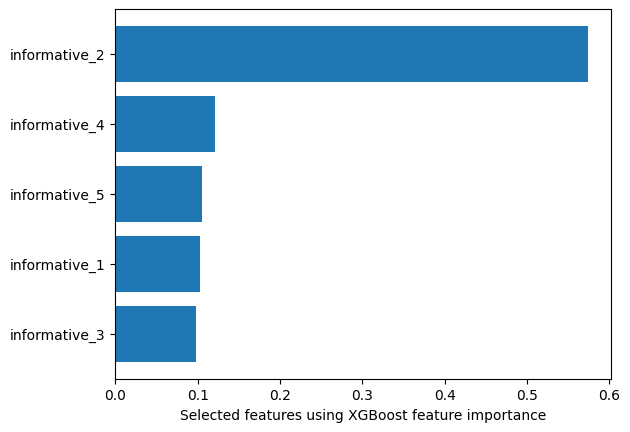

In [110]:
selected_features = model_default.support_
feature_importance = model_default.estimator_.feature_importances_
sort_idx = feature_importance.argsort()

plt.barh(df.columns[selected_features][sort_idx], feature_importance[sort_idx])
plt.xlabel("Selected features using XGBoost feature importance")

#### Experiment 1: The Shap Importance Result

In [111]:
# The shap importance model also selected 7 features
model_shap.best_score_, model_shap.n_features_

(0.977525, 5)

Exact explainer: 1601it [01:36, 14.81it/s]                          


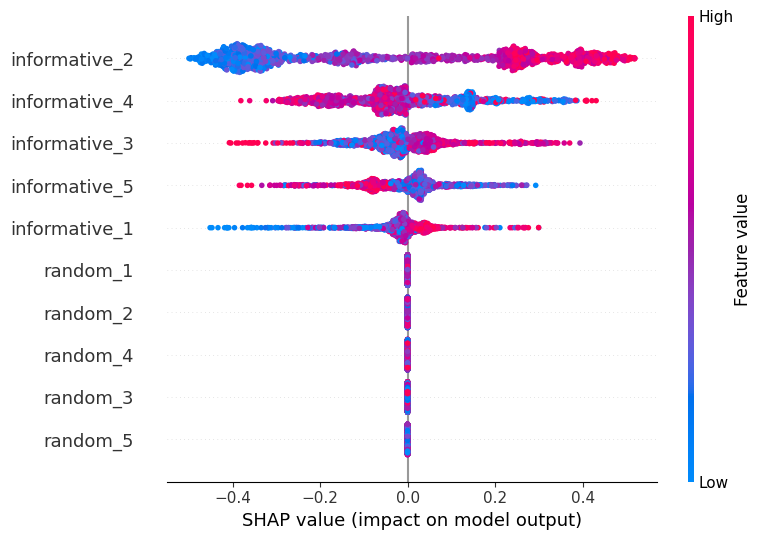

In [112]:
explainer = shap.Explainer(model_shap.predict, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values.values, X_train)

## Experiment 2

Now let's increase the complexity of the data. Add a moderator, and let the impact of two informative factors being moderated by it. Which approach would do better in this new data with interaction effect?

In [128]:
# adding moderator to the original df

df['moderator'] = np.random.randint(0, 2, size=n_samples) 
df['MainEffect_1'] = np.where(df['moderator']==0, df['informative_1'], df['informative_1']*20)
df['MainEffect_2'] = np.where(df['moderator']==0, df['informative_2'], -df['informative_2'])

col_to_drop = ['informative_1', 'informative_2']
df.drop(columns = col_to_drop, axis = 1, inplace = True)

In [115]:
df.head()

,informative_3,informative_4,informative_5,random_1,random_2,random_3,random_4,random_5,moderator,MainEffect_1,MainEffect_2
0,0.357388,1.534011,-0.215934,0.727690,0.304039,0.135582,0.849097,1.243123,0,-2.195741,-0.396964
1,-0.372284,1.477565,1.375404,-1.213560,1.484402,-0.551955,-0.538622,0.122449,1,25.902658,1.511566
2,-1.308379,3.104070,2.039705,-2.005559,1.122829,-0.527738,-0.768201,-1.463654,0,-2.395465,-1.570949
3,1.132269,1.420850,2.008977,-0.631669,-1.859734,0.913278,-0.490219,1.171117,0,-0.580540,-1.523240
4,-0.571761,3.305691,-0.055942,-0.763619,0.071469,-0.822820,-0.414769,0.524407,0,-0.137217,-2.067115


In [129]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size = 0.2, stratify=y)

In [130]:
%%time

model_default.fit(
    X_train, y_train,
    trials = Trials(),
    eval_set = [(X_valid, y_valid)],
    early_stopping_rounds=6,
    verbose=6,
    eval_metric=AUC)


10 trials detected for ('max_depth', 'learning_rate', 'colsample_bytree')

trial: 0001 ### iterations: 00049 ### eval_score: 0.9686
trial: 0002 ### iterations: 00059 ### eval_score: 0.96842
trial: 0003 ### iterations: 00029 ### eval_score: 0.9625
trial: 0004 ### iterations: 00021 ### eval_score: 0.95452
trial: 0005 ### iterations: 00007 ### eval_score: 0.94875
trial: 0006 ### iterations: 00027 ### eval_score: 0.95445
trial: 0007 ### iterations: 00009 ### eval_score: 0.94891
trial: 0008 ### iterations: 00071 ### eval_score: 0.96565
trial: 0009 ### iterations: 00009 ### eval_score: 0.95655
trial: 0010 ### iterations: 00056 ### eval_score: 0.9646
CPU times: total: 6min 25s
Wall time: 53 s


BoostBoruta(early_stopping_boruta_rounds=30,
            estimator=XGBClassifier(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraint...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
            greater_is_better=True, max_iter=200, n_iter=10,
            param_grid={'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x0000025FB2BC9FA0>,
                        'learning_rate': <hyperopt.pyll.base.Apply object at 0x0000025FB2C308E0>,
                        'max_depth': <hyperopt.pyll.base.Apply object at 0x0000025FB2C308B0>},
            sampling_seed=123)

In [118]:
%%time

model_shap.fit(
    X_train, y_train,
    trials = Trials(),
    eval_set = [(X_valid, y_valid)],
    early_stopping_rounds=6,
    verbose=6,
    eval_metric=AUC)


10 trials detected for ('max_depth', 'learning_rate', 'colsample_bytree')

trial: 0001 ### iterations: 00080 ### eval_score: 0.95817
trial: 0002 ### iterations: 00008 ### eval_score: 0.94329
trial: 0003 ### iterations: 00058 ### eval_score: 0.9548
trial: 0004 ### iterations: 00013 ### eval_score: 0.91478
trial: 0005 ### iterations: 00006 ### eval_score: 0.93354
trial: 0006 ### iterations: 00006 ### eval_score: 0.93301
trial: 0007 ### iterations: 00106 ### eval_score: 0.957
trial: 0008 ### iterations: 00143 ### eval_score: 0.9563
trial: 0009 ### iterations: 00041 ### eval_score: 0.94745
trial: 0010 ### iterations: 00058 ### eval_score: 0.94847
CPU times: total: 33min 30s
Wall time: 5min 22s


BoostBoruta(early_stopping_boruta_rounds=30,
            estimator=XGBClassifier(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraint...
                                    predictor=None, random_state=123, ...),
            greater_is_better=True, importance_type='shap_importances',
            max_iter=200, n_iter=10,
            param_grid={'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x0000025FA95A63D0>,
                        'learning_rate': <hyperopt.pyll.base.Apply object at 0x0000025FA8B3C220>,
                        'max_depth': <hyperopt.pyll.base.Apply object at 0x0000025FA8B3C8B0>},
            sampling_seed=123)

#### Experiment 2: Booster Feature Importance Results

In [119]:
model_default.best_score_, model_default.n_features_

(0.963375, 6)

Text(0.5, 0, 'Selected features using XGBoost feature importance')

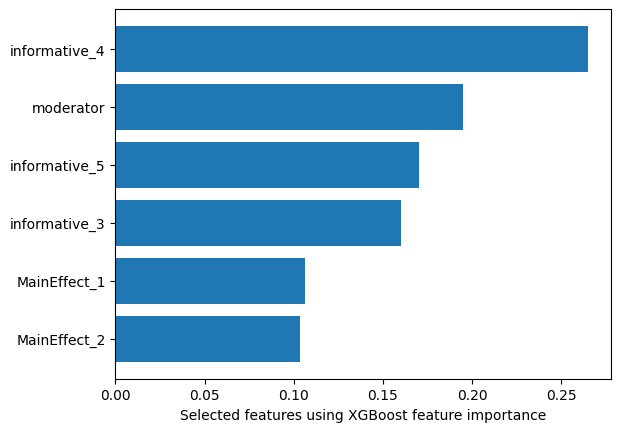

In [120]:
selected_features = model_default.support_
feature_importance = model_default.estimator_.feature_importances_
sort_idx = feature_importance.argsort()

plt.barh(df.columns[selected_features][sort_idx], feature_importance[sort_idx])
plt.xlabel("Selected features using XGBoost feature importance")

#### Experiment 2: Shap Importance Results

In [121]:
# The shap importance model also selected 7 features
model_shap.best_score_, model_shap.n_features_

(0.958175, 5)

Permutation explainer: 1601it [03:16,  7.65it/s]                          


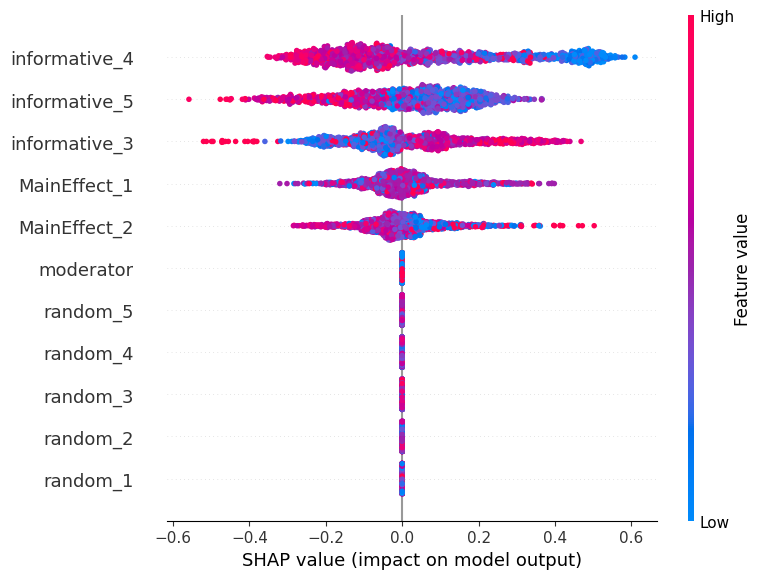

In [122]:
explainer = shap.Explainer(model_shap.predict, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values.values, X_train)

## Experiment 3. Multiple Replication/Verification of Experiment 2 

The result of experiment 2 was very interesing. Although I tried several other random numbers and got similar results (that the sharp importance feature selection tend to drop the moderator), let's verify the results in a more systematic manner. In Experiment 3, let's repeat the feature selection with 100 different random seeds.

In [162]:
def fs_moderator_comparison(random_seed, eval_metric, model_default, model_shap):
    """_summary_

    Args:
        random_seed (_type_): _description_
        model_default (_type_): _description_
        model_shap (_type_): _description_

    Returns:
        _type_: _description_
    """ 
    # Create train and valid data 
    n_samples = 2000
    n_features = 10
    n_informative = 5
    n_redundant = 0 
    n_classes = 2
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                            n_informative=n_informative, n_redundant=n_redundant,
                            n_classes=n_classes, random_state=random_seed, shuffle=False)
    informative_names = [f'informative_{i+1}' for i in range(n_informative)]
    redundant_names = [f'redundant_{i+1}' for i in range(n_redundant)]
    random_names = [f'random_{i+1}' for i in range(n_features - n_informative - n_redundant)]
    feature_names = informative_names + redundant_names + random_names
    df = pd.DataFrame(X, columns = feature_names)
    df['moderator'] = np.random.randint(0, 2, size=n_samples) 
    df['MainEffect_1'] = np.where(df['moderator']==0, df['informative_1'], df['informative_1']*20)
    df['MainEffect_2'] = np.where(df['moderator']==0, df['informative_2'], -df['informative_2'])
    col_to_drop = ['informative_1', 'informative_2']
    df.drop(columns = col_to_drop, axis = 1, inplace = True)
    X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size = 0.2, stratify=y)

    # fit feature selection model either with booster default or shap importance ranking
    model_default.fit(
    X_train, y_train,
    trials = Trials(),
    eval_set = [(X_valid, y_valid)],
    early_stopping_rounds=6,
    verbose=6,
    eval_metric=eval_metric)
    model_shap.fit(
    X_train, y_train,
    trials = Trials(),
    eval_set = [(X_valid, y_valid)],
    early_stopping_rounds=6,
    verbose=6,
    eval_metric=eval_metric)

    # record results for the run
    fs_result = pd.DataFrame()

    selected_features_default = df.columns[model_default.support_]
    informative_default = sum(1 for element in selected_features_default if 'informative' in element)
    main_default = sum(1 for element in selected_features_default if 'Main' in element)
    random_default = sum(1 for element in selected_features_default if 'random' in element)
    moderator_default = sum(1 for element in selected_features_default if 'moderator' in element)

    selected_features_shap = df.columns[model_shap.support_]
    informative_shap = sum(1 for element in selected_features_shap if 'informative' in element)
    main_shap = sum(1 for element in selected_features_shap if 'Main' in element)
    random_shap = sum(1 for element in selected_features_shap if 'random' in element)
    moderator_shap = sum(1 for element in selected_features_shap if 'moderator' in element)

    fs_result = pd.DataFrame({
        'model': ['default', 'shap'],
        'informative_features': [informative_default, informative_shap],
        'main_features': [main_default, main_shap],
        'random_features': [random_default, random_shap],
        'moderator_features': [moderator_default, moderator_shap],
        'random_seed': [random_seed, random_seed]
    })

    return fs_result

In [ ]:
# -------- run the experiment, which takes time, save the record in csv format ------#
rerun = False
if rerun: 
    # run the experiment and record performance
    fs_result_all = pd.DataFrame()
    seeds = np.random.choice(range(1, 1001), size=100, replace=False)
    for seed in seeds:
        fs_result = fs_moderator_comparison(seed, AUC, model_default, model_shap)
        fs_result_all = pd.concat([fs_result_all, fs_result], axis = 0)
    # add columns for performance metrics
    fs_result_all['total_features'] = fs_result_all[['informative_features','main_features','random_features','moderator_features']].sum(axis=1)
    fs_result_all = fs_result_all.assign(
        informative_recall = fs_result_all['informative_features']/3,
        main_recall = fs_result_all['main_features']/2,
        moderator_recall = fs_result_all['moderator_features']/1,
        feature_precision = 1- fs_result_all['random_features']/fs_result_all['total_features']
    )
    # save a copy of the result
    fs_result_all.to_csv('../data/feature_selection_experiment.csv')

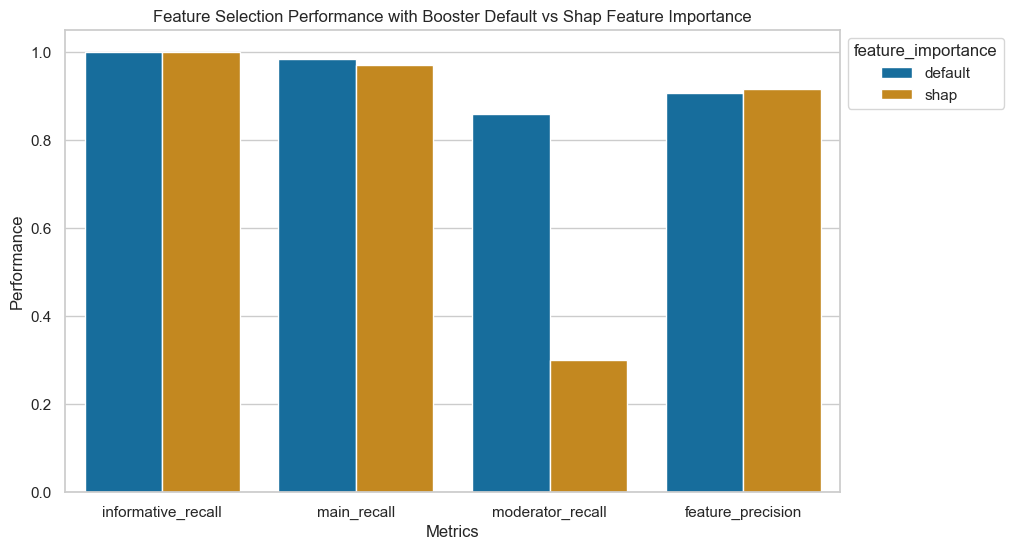

In [252]:
# summarize the performance acorss all runs
summary = fs_result_all[['model','informative_recall','main_recall','moderator_recall','feature_precision']].groupby('model').mean()
summary['feature_importance'] = summary.index
summary.reset_index(inplace = True, drop = True)
summary_pivot = summary.melt(id_vars=['feature_importance'], var_name='Metric', value_name='Value')

# visualize the result
sns.set_theme(style="whitegrid", palette = 'colorblind')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Value', hue='feature_importance', data=summary_pivot)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Metrics')
plt.ylabel('Performance')
plt.title('Feature Selection Performance with Booster Default vs Shap Feature Importance')
plt.show()